In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, PowerTransformer
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Set global plot aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 12


In [3]:
# Load dataset
file_path = 'D:\\modules\\Software Engineering Group Project\\diabetes prediction\\archive\\diabetes_prediction_dataset.csv'
df = pd.read_csv(file_path)


In [4]:
# Initial data inspection
print("First five rows of the dataset:")
display(df.head())

print("\nDataset dimensions:")
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")

print("\nDataset information:")
df.info()

print("\nStatistical summary:")
display(df.describe())


First five rows of the dataset:


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0



Dataset dimensions:
Number of rows: 100000, Number of columns: 9

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB

Statistical summary:


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [5]:
# Define numerical and categorical columns
numerical_columns = ['blood_glucose_level', 'HbA1c_level', 'bmi', 'age']
categorical_columns = ['gender', 'smoking_history', 'hypertension', 'heart_disease']
target = 'diabetes'


In [6]:
# Check skew of numerical columns
print("Skew of numerical columns:")
for col in numerical_columns:
    skewness = skew(df[col])
    print(f"{col.capitalize()}: {skewness}")

# Check kurtosis of numerical columns
print("\nKurtosis of numerical columns:")
for col in numerical_columns:
    kurt = kurtosis(df[col])
    print(f"{col.capitalize()}: {kurt}")


Skew of numerical columns:
Blood_glucose_level: 0.8216426268761283
Hba1c_level: -0.06685275833726789
Bmi: 1.0438198607100957
Age: -0.05197821709436702

Kurtosis of numerical columns:
Blood_glucose_level: 1.7374766848300727
Hba1c_level: 0.21532154566873052
Bmi: 3.5205357642212842
Age: -1.0038448150961254


In [7]:
# Address skewness using log transformation where appropriate
for col in ['blood_glucose_level', 'bmi']:  # Apply to skewed features
    df[col] = np.log1p(df[col])

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")

Missing values in each column:
No missing values found.


In [9]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 3854


In [10]:
# Remove duplicate rows and check for duplicate rows
if duplicate_rows > 0:
    df = df.drop_duplicates()
    print("Duplicate rows removed.")
    duplicate_rows = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_rows}")

Duplicate rows removed.
Number of duplicate rows: 0


In [11]:
# Outlier Detection
print("Outlier detection using IQR method:")

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers")


Outlier detection using IQR method:
blood_glucose_level: 0 outliers
HbA1c_level: 1312 outliers
bmi: 6398 outliers
age: 0 outliers


In [12]:
# Unique Value Counts
top_n = 5  # Number of top values to display
bottom_n = 5  # Number of bottom values to display

for col in df.columns:
    unique_counts = df[col].value_counts()
    print(f"\nColumn: {col}")
    
    if unique_counts.size > (top_n + bottom_n):
        top_values = unique_counts.head(top_n)
        bottom_values = unique_counts.tail(bottom_n)
        combined = pd.concat([top_values, pd.Series(['...'], index=['...']), bottom_values])
    else:
        combined = unique_counts
    
    display(pd.DataFrame({'Unique Value': combined.index, 'Count': combined.values}))



Column: gender


,Unique Value,Count
0,Female,56161
1,Male,39967
2,Other,18



Column: age


,Unique Value,Count
0,80.0,4932
1,51.0,1566
2,47.0,1511
3,48.0,1508
4,53.0,1498
5,...,...
6,0.48,83
7,1.0,83
8,0.4,66
9,0.16,59



Column: hypertension


,Unique Value,Count
0,0,88685
1,1,7461



Column: heart_disease


,Unique Value,Count
0,0,92223
1,1,3923



Column: smoking_history


,Unique Value,Count
0,never,34398
1,No Info,32887
2,former,9299
3,current,9197
4,not current,6367
5,ever,3998



Column: bmi


,Unique Value,Count
0,3.343568,21666
1,3.178054,103
2,3.336481,101
3,3.256557,100
4,3.360375,100
5,...,...
6,4.081428,1
7,3.895487,1
8,4.035479,1
9,4.061649,1



Column: HbA1c_level


,Unique Value,Count
0,6.6,8164
1,5.7,8124
2,6.5,8051
3,5.8,7992
4,6.0,7988
5,...,...
6,8.2,659
7,9.0,652
8,7.5,642
9,6.8,642



Column: blood_glucose_level


,Unique Value,Count
0,5.075174,7478
1,4.875197,7471
2,4.844187,7421
3,4.94876,7416
4,5.081404,7397
5,...,...
6,5.638355,724
7,5.70711,673
8,5.56452,634
9,5.484797,633



Column: diabetes


,Unique Value,Count
0,0,87664
1,1,8482


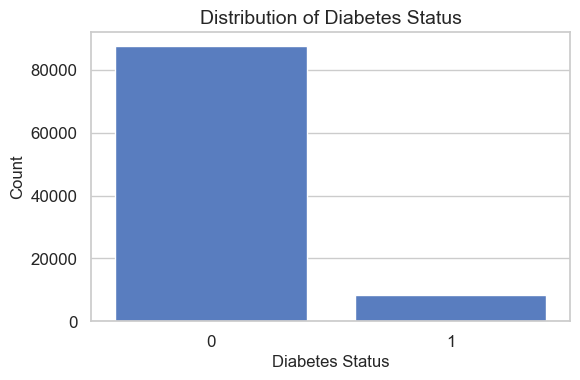

Class Distribution (%):
diabetes
0    91.178
1     8.822
Name: proportion, dtype: float64


In [13]:
# Target Variable Distribution

# Count plot
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df)
plt.title('Distribution of Diabetes Status')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Class distribution percentages
class_distribution = df[target].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(class_distribution)


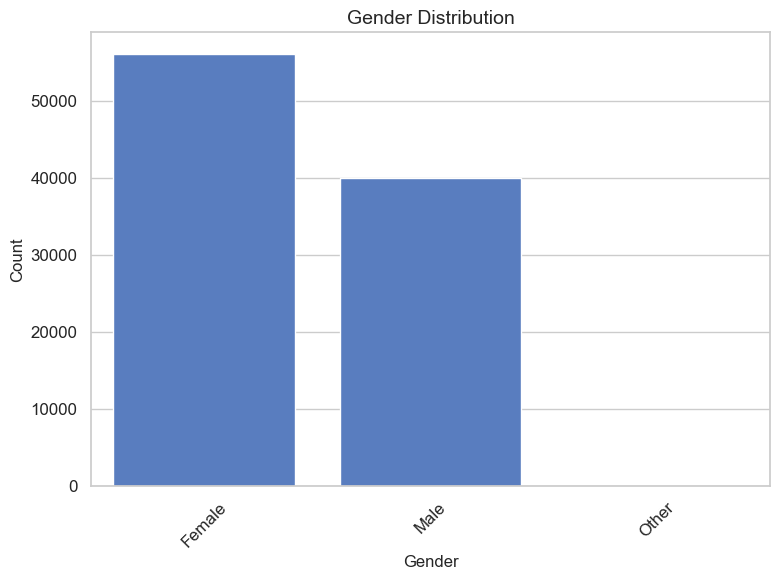

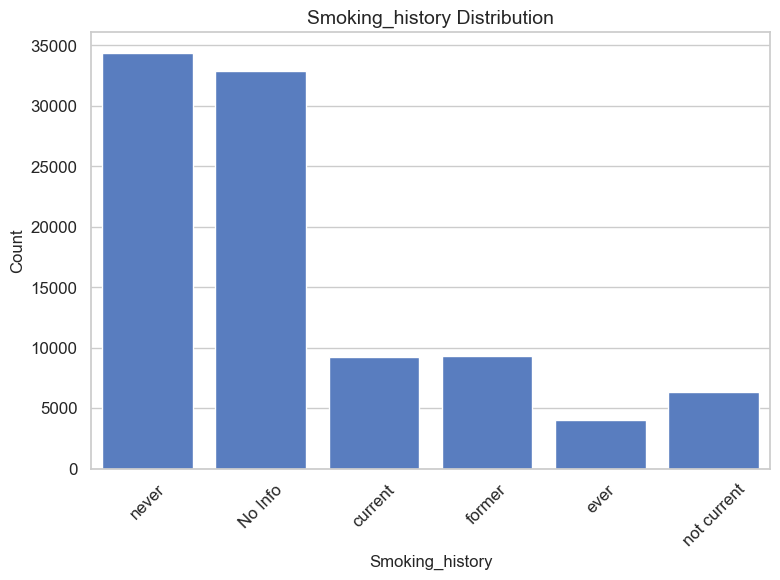

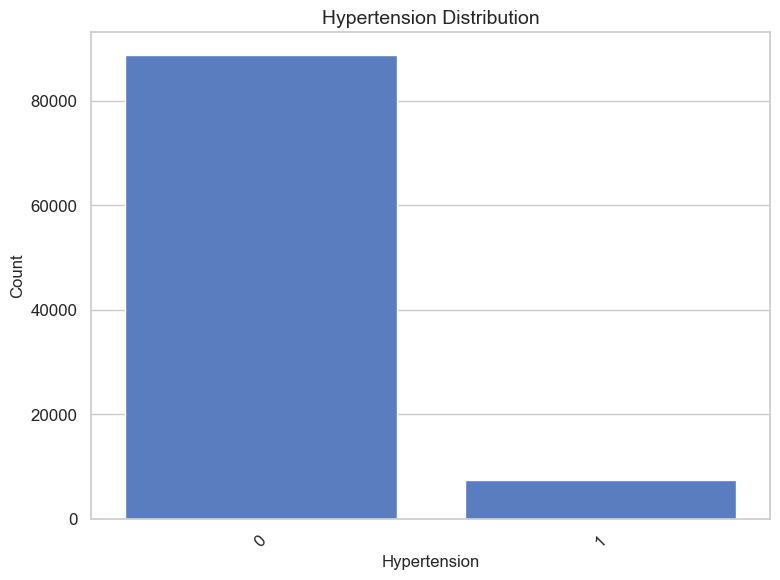

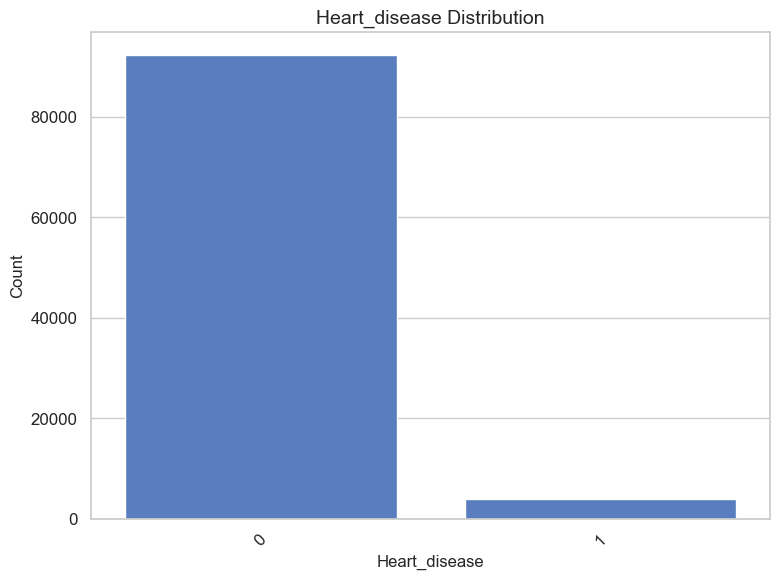

In [14]:
# Categorical Features Analysis

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, data=df)
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


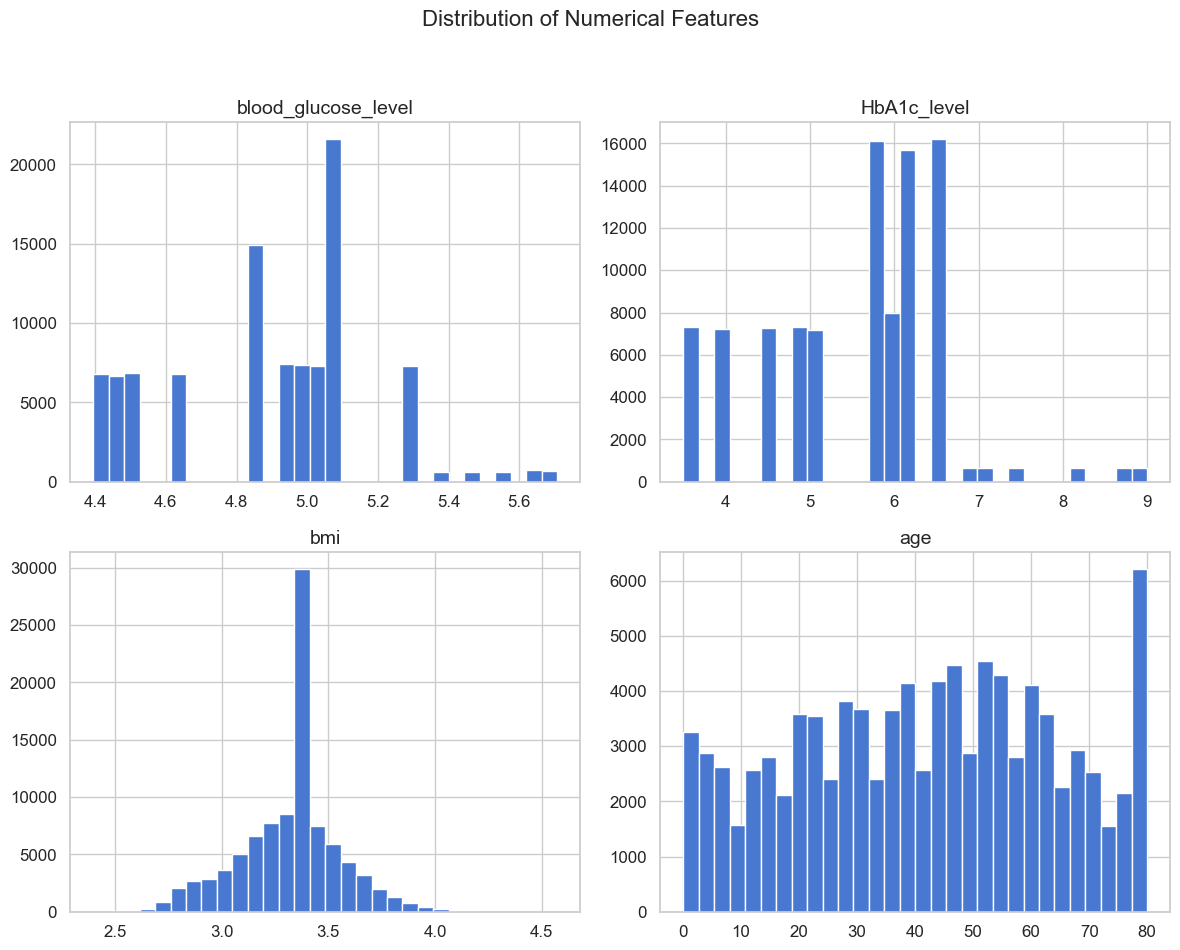

In [15]:
# Numerical Features Histogram
df[numerical_columns].hist(bins=30, figsize=(12, 10))
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


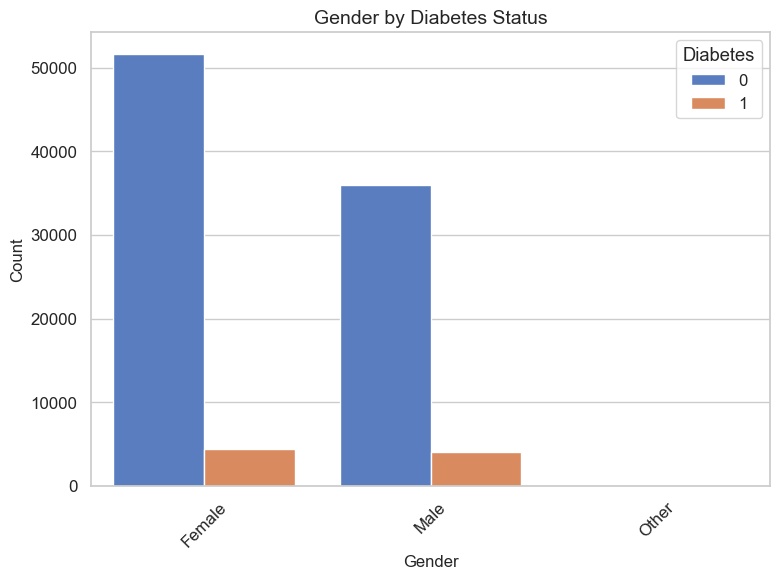

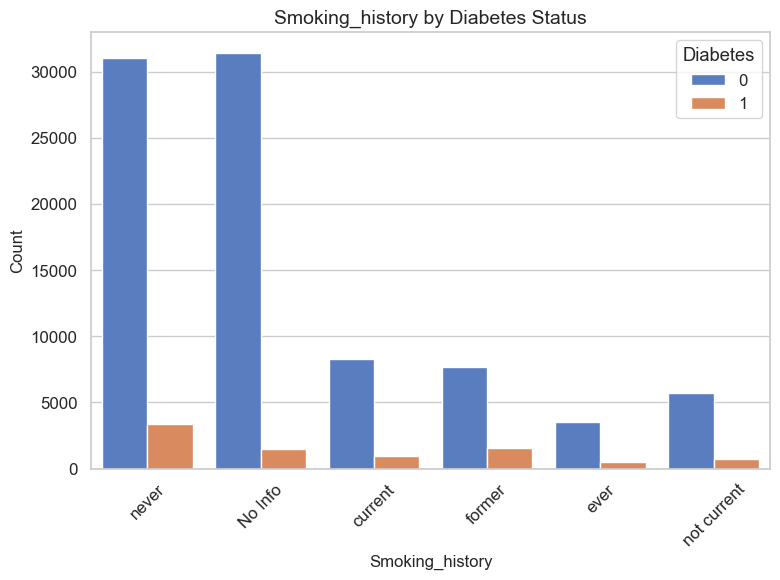

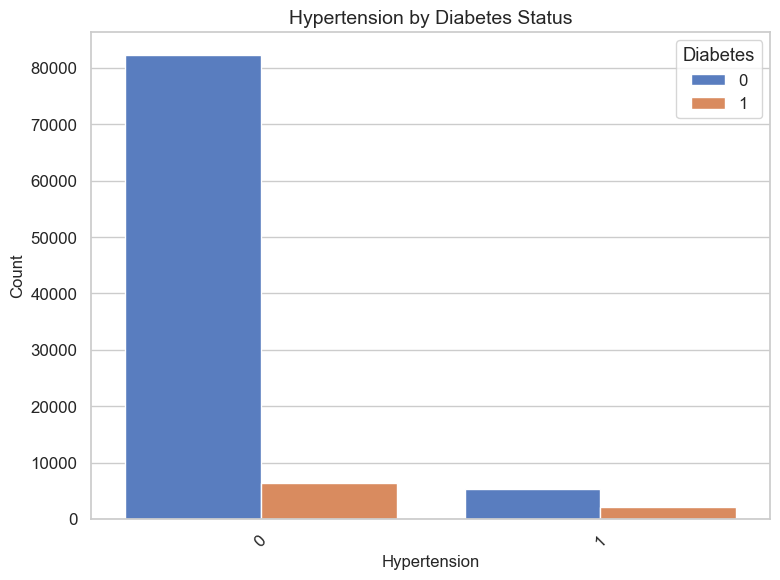

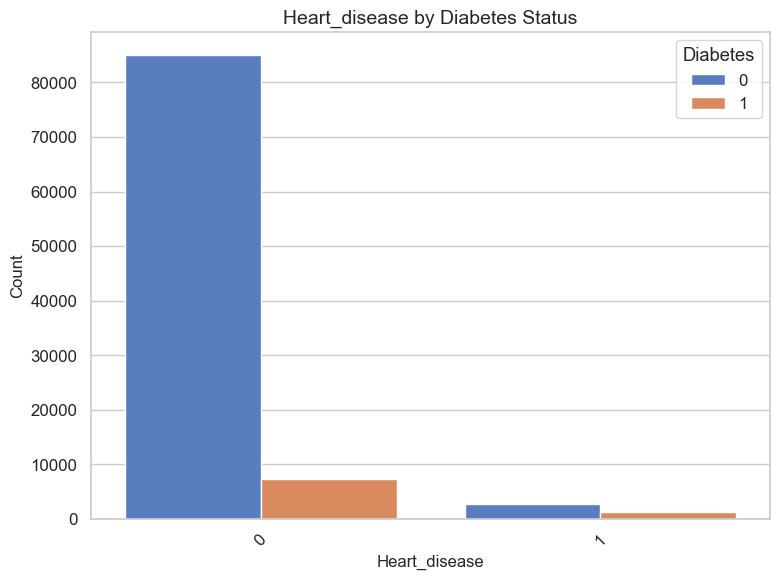

In [16]:
# Categorical Features vs. Diabetes Status

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue=target, data=df)
    plt.title(f'{col.capitalize()} by Diabetes Status')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='Diabetes', loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


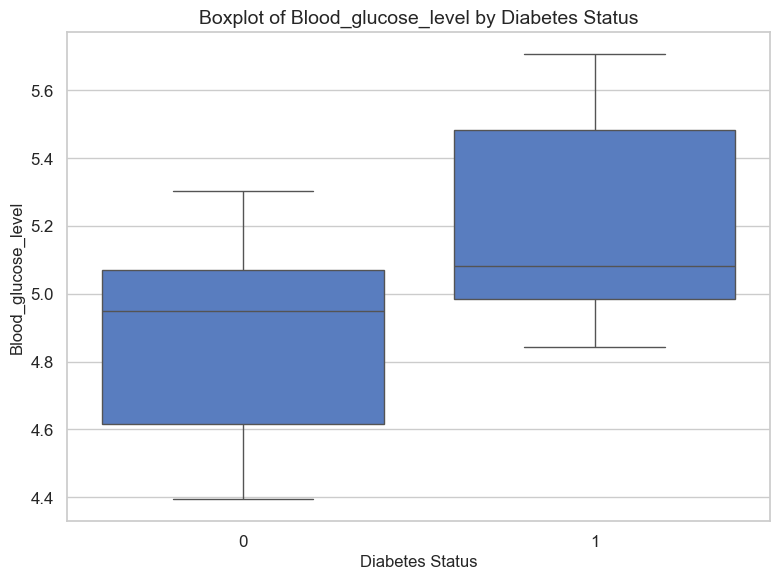

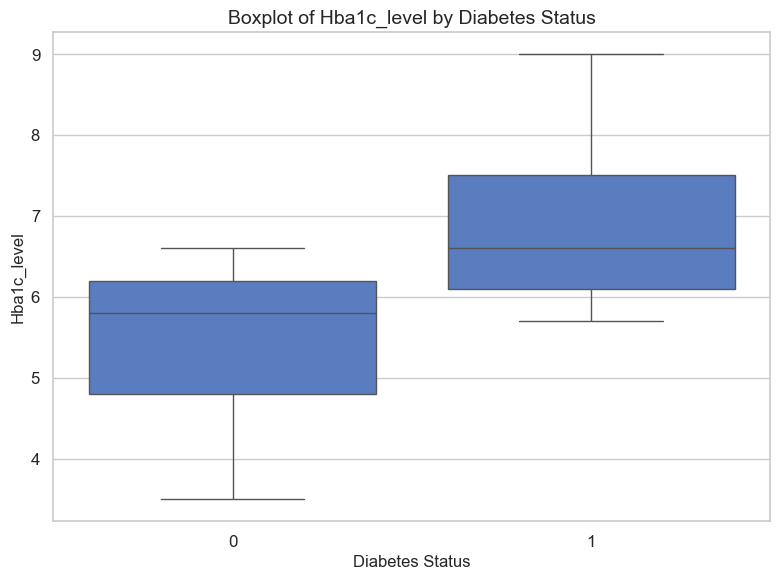

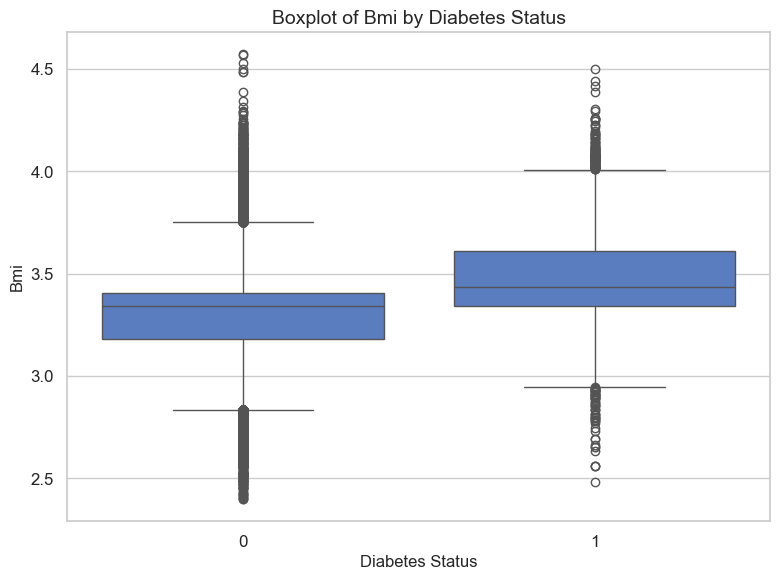

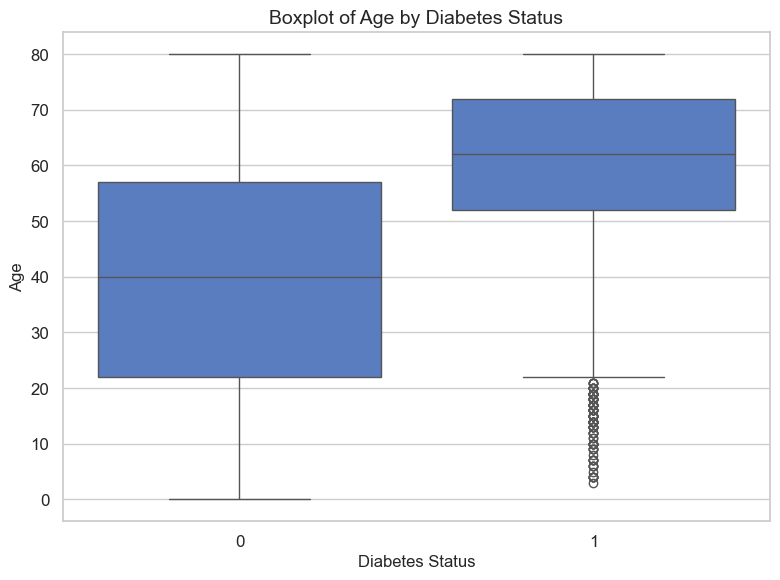

In [17]:
# Boxplots of Numerical Features by Diabetes Status

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'Boxplot of {col.capitalize()} by Diabetes Status')
    plt.xlabel('Diabetes Status')
    plt.ylabel(col.capitalize())
    plt.tight_layout()
    plt.show()


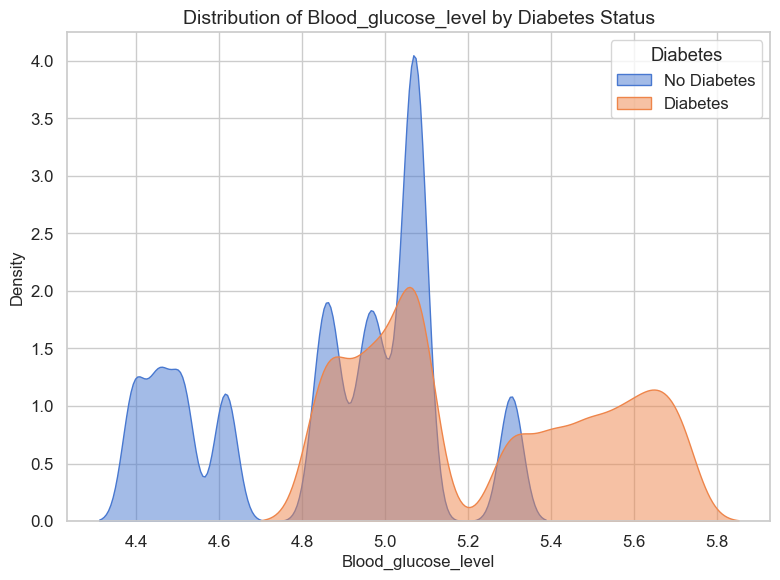

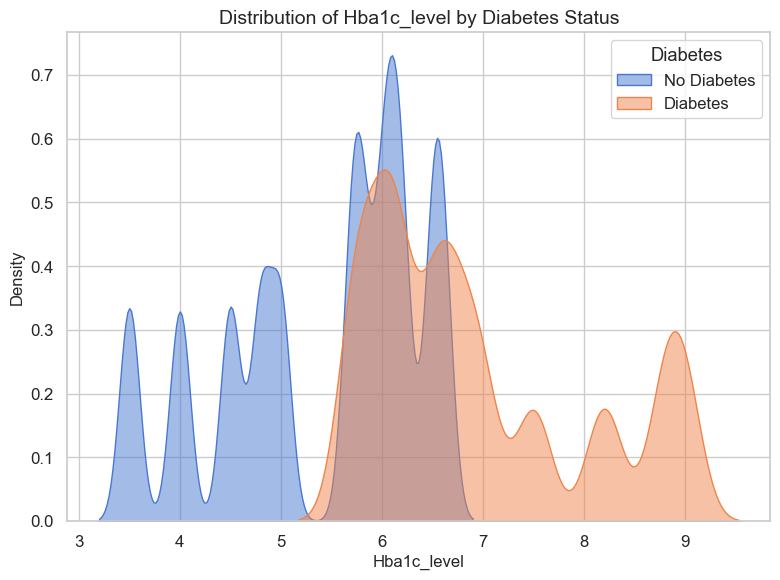

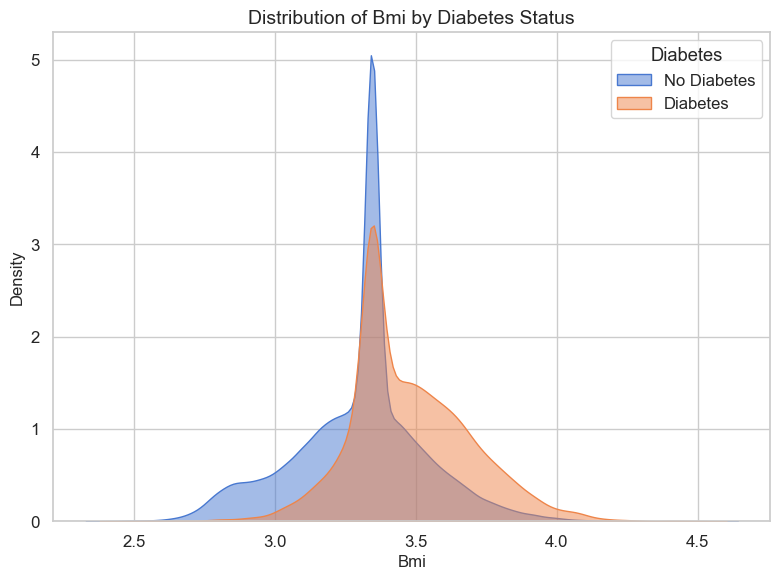

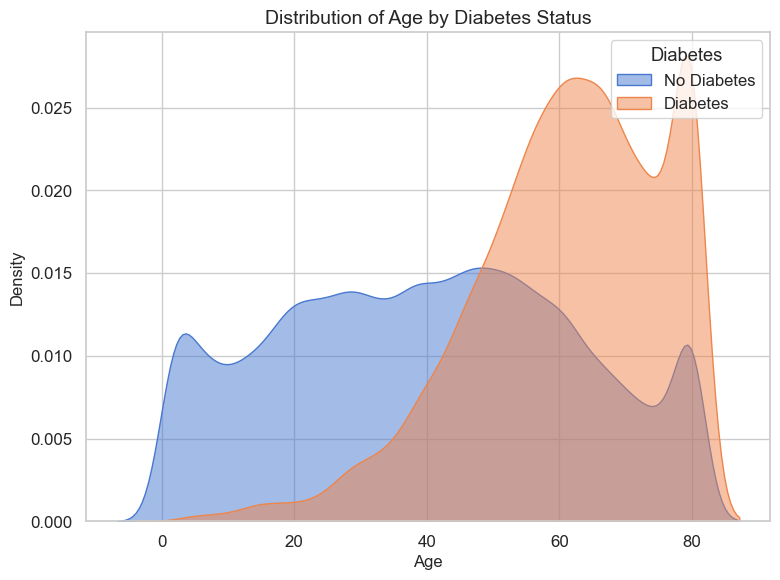

In [18]:
# KDE Plots of Numerical Features by Diabetes Status

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    # Create the KDE plot for No Diabetes
    sns.kdeplot(data=df[df[target] == 0], x=col, label='No Diabetes', fill=True, common_norm=False, alpha=0.5)
    # Create the KDE plot for Diabetes
    sns.kdeplot(data=df[df[target] == 1], x=col, label='Diabetes', fill=True, common_norm=False, alpha=0.5)
    
    plt.title(f'Distribution of {col.capitalize()} by Diabetes Status')
    plt.xlabel(col.capitalize())
    plt.ylabel('Density')
    plt.legend(title='Diabetes')
    plt.tight_layout()
    plt.show()


In [19]:
# Correlation Matrix Calculation

corr_matrix = df[numerical_columns + [target]].corr()
print("Correlation Matrix:")
display(corr_matrix)


Correlation Matrix:


,blood_glucose_level,HbA1c_level,bmi,age,diabetes
blood_glucose_level,1.000000,0.144436,0.075199,0.096373,0.357140
HbA1c_level,0.144436,1.000000,0.081464,0.106719,0.406408
bmi,0.075199,0.081464,1.000000,0.404074,0.207386
age,0.096373,0.106719,0.404074,1.000000,0.264927
diabetes,0.357140,0.406408,0.207386,0.264927,1.000000


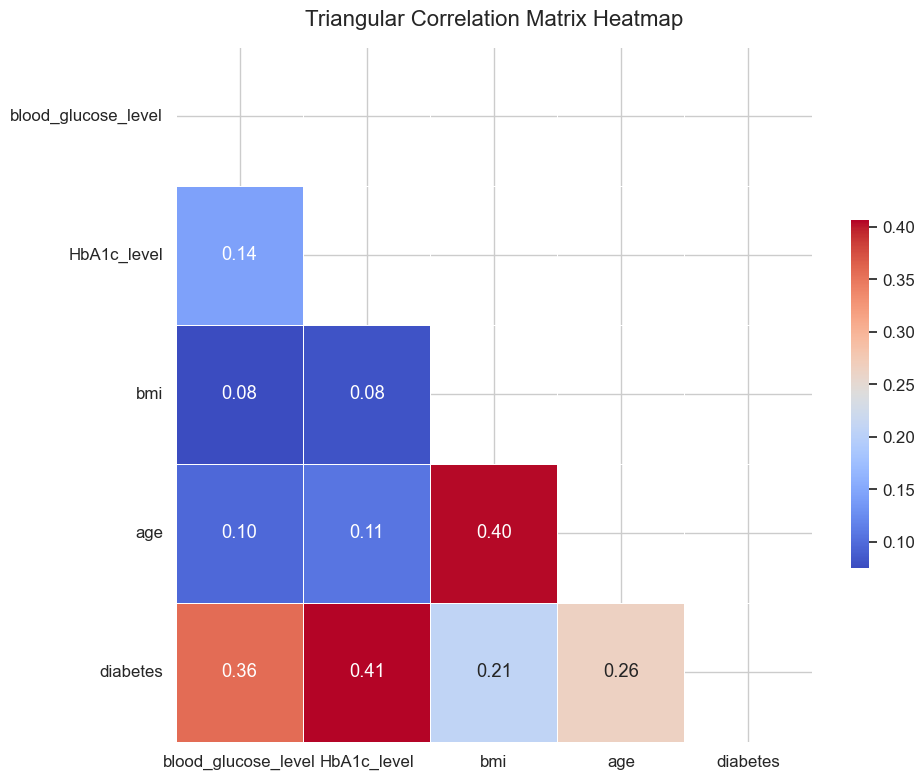

In [20]:
# Triangular Heatmap of Correlation Matrix

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title('Triangular Correlation Matrix Heatmap', fontsize=16, pad=15)
plt.tight_layout()
plt.show()


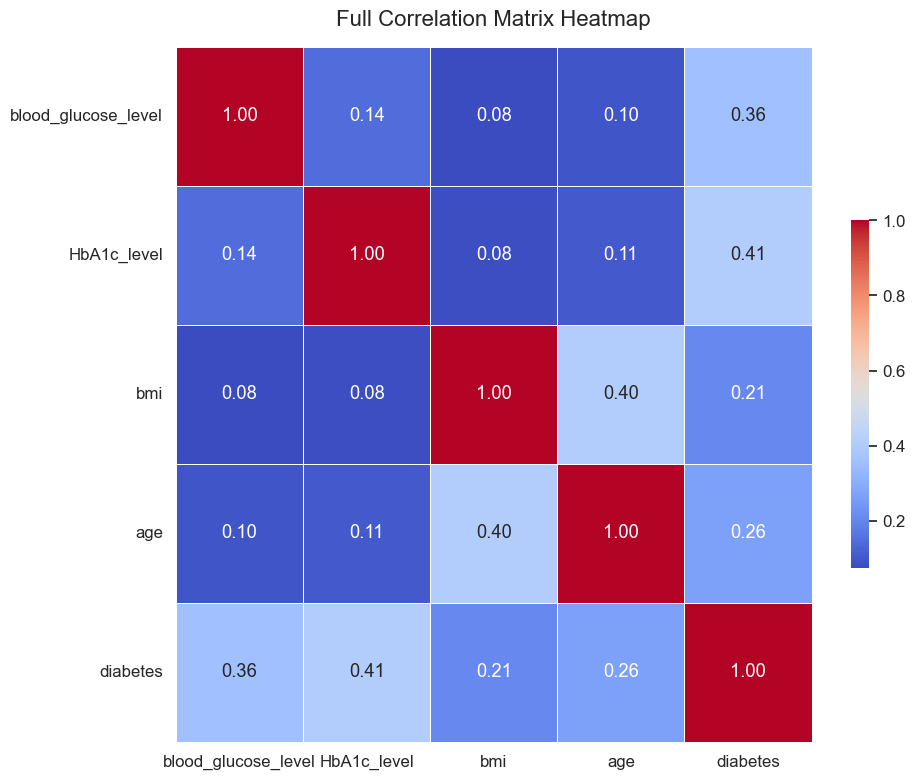

In [21]:
# Full Heatmap of Correlation Matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title('Full Correlation Matrix Heatmap', fontsize=16, pad=15)
plt.tight_layout()
plt.show()


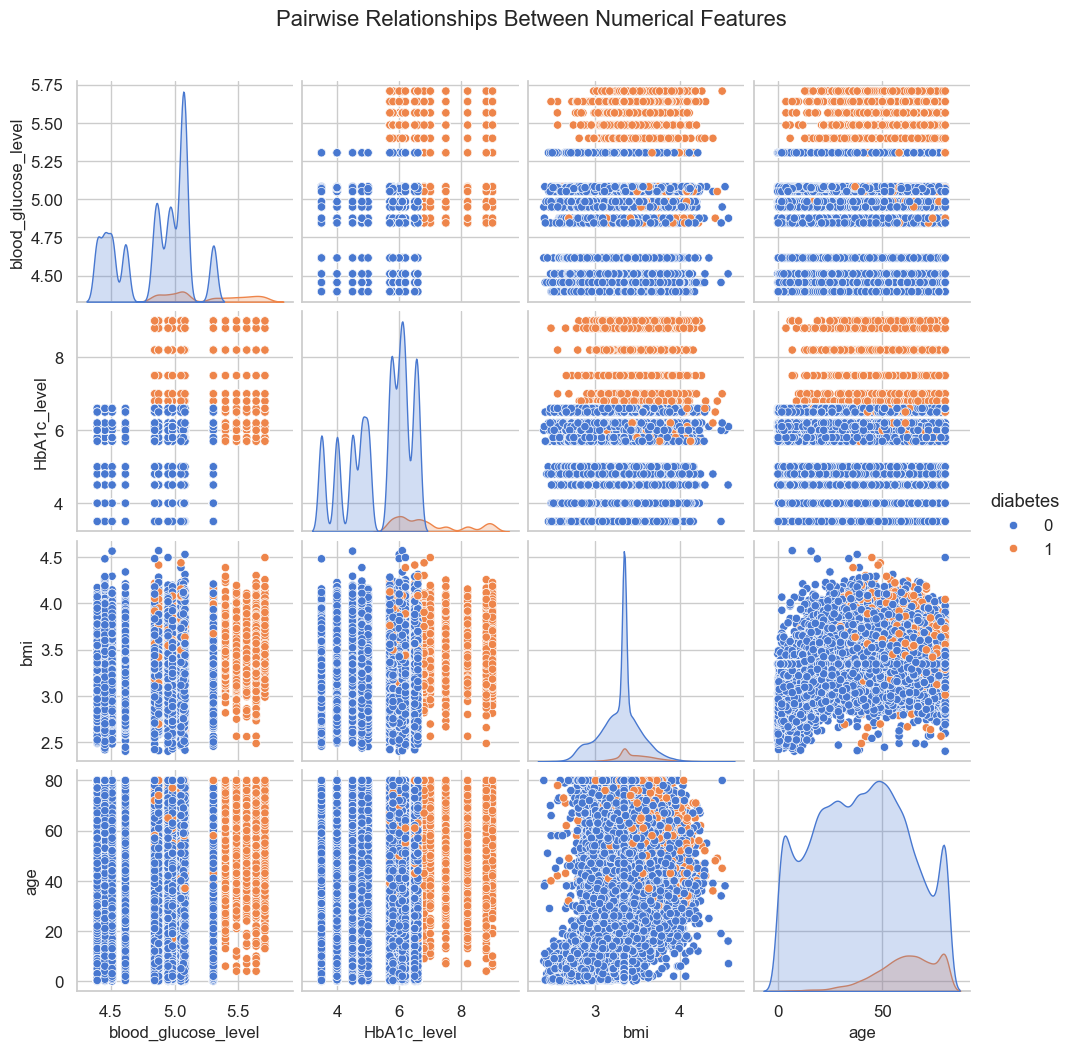

In [22]:
# Pairplot of Numerical Features

sns.pairplot(df, vars=numerical_columns, hue=target, diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Numerical Features', y = 1.05)
plt.show()

In [23]:
# One-Hot Encoding of Categorical Variables

# Perform one-hot encoding with n-1 categories to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype = int)

print("One-hot encoded dataset:")
display(df_encoded.head())


One-hot encoded dataset:


,age,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,hypertension_1,heart_disease_1
0,80.0,3.265378,6.6,4.948760,0,0,0,0,0,0,1,0,0,1
1,54.0,3.343568,6.6,4.394449,0,0,0,0,0,0,0,0,0,0
2,28.0,3.343568,5.7,5.068904,0,1,0,0,0,0,1,0,0,0
3,36.0,3.196630,5.0,5.049856,0,0,0,1,0,0,0,0,0,0
4,76.0,3.051167,4.8,5.049856,0,1,0,1,0,0,0,0,1,1


In [24]:
# Multicollinearity Check using VIF

# Calculate VIF for each numerical feature in the one-hot encoded dataset
X = df_encoded.drop(columns=[target])  # Drop the target column for VIF calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF) for each feature:")
display(vif_data)


Variance Inflation Factor (VIF) for each feature:


,Feature,VIF
0,age,6.055027
1,bmi,148.059172
2,HbA1c_level,28.253338
3,blood_glucose_level,143.934242
4,gender_Male,1.743965
5,gender_Other,1.000864
6,smoking_history_current,1.320558
7,smoking_history_ever,1.151971
8,smoking_history_former,1.423230
9,smoking_history_never,2.200702


In [25]:
# Handle class imbalance using SMOTE
X = df_encoded.drop(columns='diabetes')
y = df_encoded['diabetes']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

print("Class distribution after resampling:")
print(y_resampled.value_counts(normalize=True))

Class distribution after resampling:
diabetes
0    0.5
1    0.5
Name: proportion, dtype: float64


In [26]:
df_resampled.to_csv('diabetes_prediction_dataset_encoded_resampled.csv', index=False)